In [1]:
# Transfer Learning: Modify the last layer of the model to fit the new dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # can change the learning rate
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = { 'train' : transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]),
    'val' : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]),
}

data_dir = 'data/hymenoptera_data'
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)

['ants', 'bees']


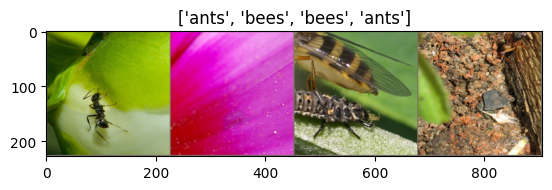

In [3]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)
        
        
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
                
            else:
                model.eval()
                
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model

In [5]:
# training the model from scratch; Also known as finetuning
# This changes the wieghts of the model to fit the new dataset
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

critertion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, critertion, optimizer, step_lr_scheduler, num_epochs=25)

c:\Users\hp\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hp\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------
train Loss: 0.6144 Acc: 0.6803
val Loss: 0.4288 Acc: 0.8562

Epoch 2/25
----------
train Loss: 0.4765 Acc: 0.7869
val Loss: 0.3198 Acc: 0.9281

Epoch 3/25
----------
train Loss: 0.4792 Acc: 0.7623
val Loss: 0.2683 Acc: 0.9542

Epoch 4/25
----------
train Loss: 0.4427 Acc: 0.7992
val Loss: 0.2438 Acc: 0.9281

Epoch 5/25
----------
train Loss: 0.3929 Acc: 0.8074
val Loss: 0.2105 Acc: 0.9739

Epoch 6/25
----------
train Loss: 0.3402 Acc: 0.8566
val Loss: 0.2387 Acc: 0.9216

Epoch 7/25
----------
train Loss: 0.4030 Acc: 0.8156
val Loss: 0.1913 Acc: 0.9608

Epoch 8/25
----------
train Loss: 0.4176 Acc: 0.7992
val Loss: 0.2041 Acc: 0.9477

Epoch 9/25
----------
train Loss: 0.3195 Acc: 0.8566
val Loss: 0.2105 Acc: 0.9412

Epoch 10/25
----------
train Loss: 0.3275 Acc: 0.8443
val Loss: 0.2091 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.3362 Acc: 0.8648
val Loss: 0.1941 Acc: 0.9542

Epoch 12/25
----------
train Loss: 0.3193 Acc: 0.8689
val Loss: 0.2069 Acc: 0.9412

E

In [7]:
# training model for only the last layer
model = models.resnet18(pretrained=True)
for param in model.parameters(): # freeze all the parameters in the beginning except the last layer
    param.requires_grad = False
    
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

critertion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, critertion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6652 Acc: 0.6107
val Loss: 0.5063 Acc: 0.7843

Epoch 2/25
----------
train Loss: 0.5699 Acc: 0.7090
val Loss: 0.4021 Acc: 0.8758

Epoch 3/25
----------
train Loss: 0.5222 Acc: 0.7418
val Loss: 0.3511 Acc: 0.8889

Epoch 4/25
----------
train Loss: 0.4717 Acc: 0.8115
val Loss: 0.3232 Acc: 0.9216

Epoch 5/25
----------
train Loss: 0.4833 Acc: 0.7992
val Loss: 0.2825 Acc: 0.9477

Epoch 6/25
----------
train Loss: 0.4705 Acc: 0.7828
val Loss: 0.2574 Acc: 0.9412

Epoch 7/25
----------
train Loss: 0.4279 Acc: 0.8320
val Loss: 0.2444 Acc: 0.9477

Epoch 8/25
----------
train Loss: 0.4193 Acc: 0.8238
val Loss: 0.2415 Acc: 0.9477

Epoch 9/25
----------
train Loss: 0.4088 Acc: 0.8443
val Loss: 0.2477 Acc: 0.9346

Epoch 10/25
----------
train Loss: 0.4274 Acc: 0.8279
val Loss: 0.2566 Acc: 0.9412

Epoch 11/25
----------
train Loss: 0.4599 Acc: 0.7869
val Loss: 0.2392 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.3702 Acc: 0.8730
val Loss: 0.2433 Acc: 0.9346

E